In [ ]:
import uproot
import h5py
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict

In [ ]:
# def printattr(name, object):
#     print(name)
# h5py_file = h5py.File('ttbar_testing_mass_variation/ttbar_testing_170_gev.h5', "r")
# h5py_file.visititems(printattr)

In [ ]:
# The reco_top_mss from ttbar_testing_mass_variation
mass = [170, 171, 172, 173, 174, 175, 176]
reco_dic = {}
state_dic = {} # 0 for unmatched, 1 for incorrect, 2 for correct
state_labels = ['Unmatched', 'Incorrect', 'Correct']

for m in mass:
    h5py_file = h5py.File('ttbar_testing_mass_variation/ttbar_testing_{}_gev.h5'.format(m), "r")
    cut = np.logical_and(h5py_file['spanet/reconstructed_top_mass'][:]>100, h5py_file['spanet/reconstructed_top_mass'][:]<300)
    reco_dic[m] = h5py_file['spanet/reconstructed_top_mass'][:][cut]

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q1'][:] == -1))
    state = np.where(unmatch, 0, state)

    # Two permutations for q1 and q2.
    a = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file['spanet/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file['spanet/right_target/q2'][:])
    b = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file['spanet/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file['spanet/right_target/q1'][:])
    a_or_b = np.logical_or(a, b)
    right = np.logical_and(a_or_b, h5py_file['target/right_target/b'][:] == h5py_file['spanet/right_target/b'][:])
    state = np.where(right, 2, state)
    state_dic[m] = state[cut]

In [ ]:
# Fixed the bins for all plots.
bins = np.arange(100, 301, 2)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
tot_event = 100000

In [ ]:
h5py_file = h5py.File('ttbar_testing_sm/ttbar_testing_sm.h5', "r")
cut = np.logical_and(h5py_file['spanet/reconstructed_top_mass'][:]>100, h5py_file['spanet/reconstructed_top_mass'][:]<300)
reco = h5py_file['spanet/reconstructed_top_mass'][:][cut]
# Inital set all to incorrect.
state = [1]*len(h5py_file['target/right_target/q1'][:])

# If -1 exists, set it to unmatch.
unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                    h5py_file['target/right_target/q1'][:] == -1,
                    h5py_file['target/right_target/q1'][:] == -1))
state = np.where(unmatch, 0, state)

# If all correct (one of the two permutations), set to correct.
a = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file['spanet/right_target/q1'][:], 
                    h5py_file['target/right_target/q2'][:] == h5py_file['spanet/right_target/q2'][:])
b = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file['spanet/right_target/q2'][:], 
                    h5py_file['target/right_target/q2'][:] == h5py_file['spanet/right_target/q1'][:])
a_or_b = np.logical_or(a, b)
right = np.logical_and(a_or_b, h5py_file['target/right_target/b'][:] == h5py_file['spanet/right_target/b'][:])
state = np.where(right, 2, state)
state = state[cut]

In [ ]:
plt.figure(figsize=(7,7))
state_labels = ['Unmatched', 'Incorrect', 'Correct']
h = [0]*(len(bins)-1)

for i in [2, 1, 0]:
    ratio = np.count_nonzero(state==i)/len(state)
    hist, bin_edges = np.histogram(reco[state==i], bins=bins)
    plt.bar(bin_edges[:-1]+0.5, hist, bottom=h, edgecolor=colors[i], width=2, color='None', label = state_labels[i] + ' ratio: ' + str(round(ratio, 3)))
    h += hist
plt.title('ttbar_testing_sm')
plt.xlim(100, 300)
plt.xlabel('reco top mass (GeV)')
plt.ylabel('event/2GeV')
plt.legend(loc='upper right')
plt.show()

In [ ]:
for m in mass:
    plt.figure(figsize=(7,7))
    h = [0]*(len(bins)-1)
    
    for i in [2, 1, 0]:
        ratio = np.count_nonzero(state_dic[m]==i)/len(state_dic[m])
        hist, bin_edges = np.histogram(reco_dic[m][state_dic[m] == i], bins=bins)
        plt.bar(bin_edges[:-1]+0.5, hist, bottom=h, edgecolor=colors[i], width=2, color='None', label = state_labels[i] + ' ratio: ' + str(round(ratio, 3)))
        h += hist
    plt.title('ttbar_testing_mass_variation top mass = {}'.format(m))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/2GeV')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
for i, m in enumerate(mass):
    plt.figure(figsize=(7,7))
    hist1, bin_edges = np.histogram(reco_dic[m], bins=bins)
    hist1 = hist1*tot_event/sum(hist1)
    hist2, bin_edges = np.histogram(reco, bins=bins)
    hist2 = hist2*tot_event/sum(hist2)
    plt.bar(bin_edges[:-1]+0.5, hist1, edgecolor='blue', width=2, color='None', label = 'MC event top mass = {}'.format(m))
    plt.bar(bin_edges[:-1]+0.5, hist2, edgecolor='red', width=2, color='None', label = 'Target')
    plt.bar(bin_edges[:-1]+0.5, hist1-hist2, edgecolor='black', width=2, color='None', label = 'Difference between event')
    plt.title('ttbar_testing_mass_variation, total event = {}'.format(tot_event))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/GeV')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized version
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
def langau(x, lan_size, lan_loc, lan_scale, gau_size, gau_loc, gau_scale):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return lan_size*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + gau_size*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Normalized landau distribution.
def lan_norm(x, lan_loc, lan_scale):
    lan_y = (x-lan_loc)/lan_scale
    return np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale

# One gaussian distribution.
def gau_norm(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

# Two gaussian distributions.
def two_gau_norm(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    gau_y1 = (x-gau_loc1)/gau_scale1
    gau_y2 = (x-gau_loc2)/gau_scale2
    return (1-f)*np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1 + f*np.exp(-gau_y2**2/2)/np.sqrt(2*np.pi)/gau_scale2

# Linear
def linear(x, a, b):
    return a*x+b

In [ ]:
def chi2_pdf(mt1, n2): #mt1 is the observation, n2 is the height of the bins from pdf.
    n1, _ = np.histogram(mt1, bins=bins)
    n2 *= 2*len(mt1)
    chi2_value = 2*sum([n2[i] - n1[i] + n1[i]*np.log(n1[i]/n2[i]) if n1[i]!=0 else n2[i] for i in range(len(n1))])
    return chi2_value

gau [170.20701182  46.92956978]
lan [157.19085749  26.9422439 ]
langau [202.09926305  25.9576776  151.96686003  25.77519673   0.54092099]


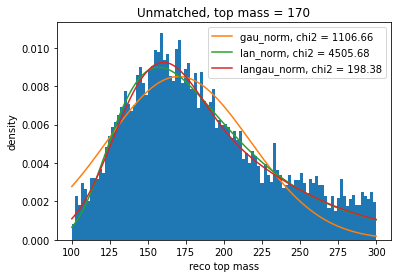

gau [171.65718157  47.04208465]
lan [158.63238147  26.94790192]
langau [201.86111266  26.83815188 153.01268861  25.4807826    0.52426583]


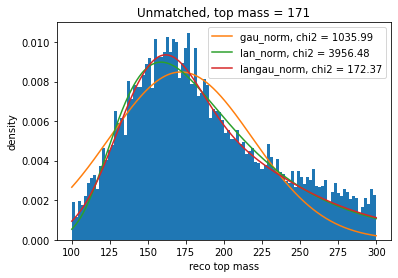

gau [172.33668977  46.89417762]
lan [159.13367204  26.86803895]
langau [207.5550903   26.05575203 155.04343687  25.72324805   0.56049278]


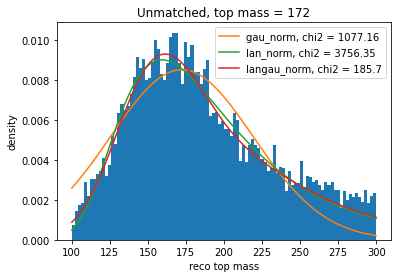

gau [172.7278344   48.26512823]
lan [159.09653256  27.60007385]
langau [206.73693146  25.76939995 153.79603753  25.75432736   0.54457676]


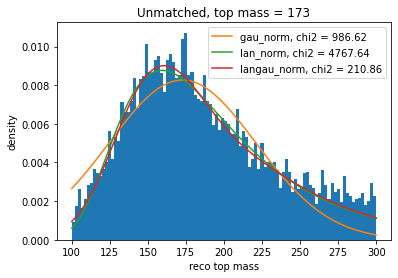

gau [173.39733305  47.91133113]
lan [159.78952359  27.3493502 ]
langau [182.12354371  26.00343668 143.17270242  23.08584841   0.31474014]


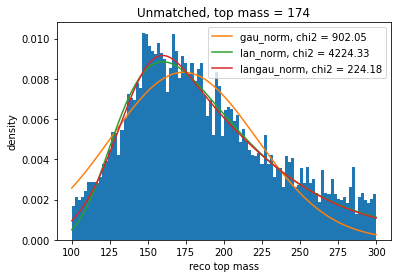

gau [173.02511631  48.10657776]
lan [159.38396896  27.5236077 ]
langau [234.48585944  22.43998103 163.11674341  31.05743202   0.72238493]


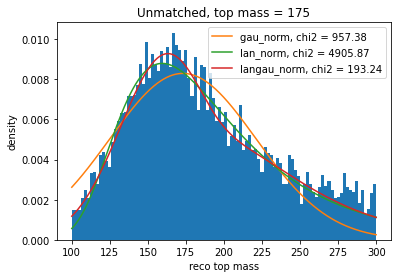

gau [174.4195985   46.57224602]
lan [161.22214813  27.1048626 ]
langau [1.60997381e+02 2.95010571e+01 1.71278896e+02 1.79077770e+01
 8.61091897e-02]


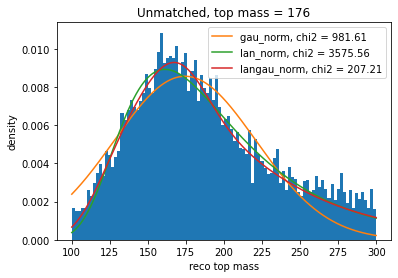

gau [172.21759937  37.70744628]
lan [161.24817777  22.60458997]
langau [195.88879544  23.73854529 158.0376981   24.01163703   0.5563665 ]


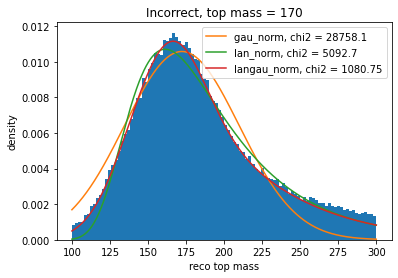

gau [172.41313019  37.58215471]
lan [161.49862558  22.54790479]
langau [160.98017486  26.38188888 170.99224091  18.31919716   0.17357575]


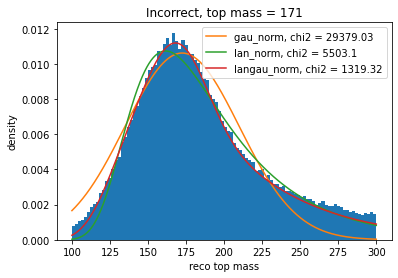

gau [172.65312069  37.68637275]
lan [161.64885205  22.57404771]
langau [1.61286982e+02 2.61612089e+01 1.70942910e+02 1.81936133e+01
 1.62872470e-01]


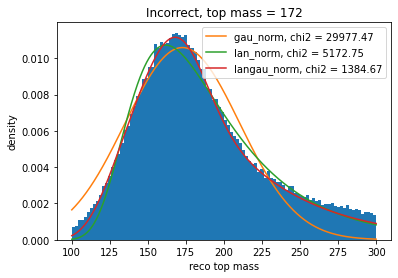

gau [173.34573243  37.6890658 ]
lan [162.41774404  22.59476885]
langau [195.01683278  23.84415617 158.64929452  24.04828022   0.53964796]


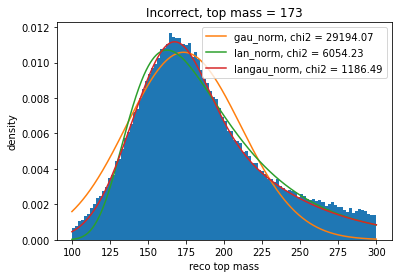

gau [173.48945331  37.74303512]
lan [162.47256723  22.62252807]
langau [197.58490839  23.70096535 159.29050125  24.01230477   0.55910337]


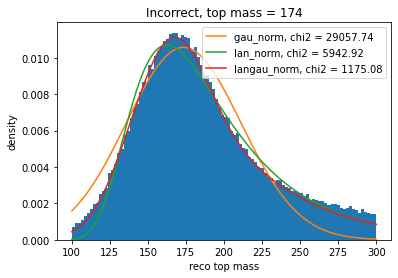

gau [173.80563051  37.72026376]
lan [162.85606633  22.64045868]
langau [162.53263559  26.66563477 171.97509829  18.41195813   0.17767083]


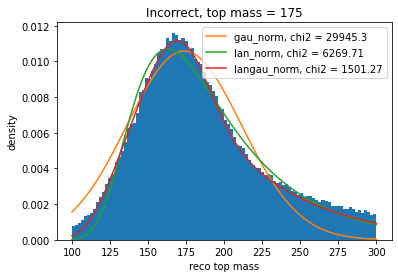

gau [174.3169354   38.10866943]
lan [163.19204237  22.79395951]
langau [195.48192939  23.68285011 158.8463504   23.87232932   0.52849874]


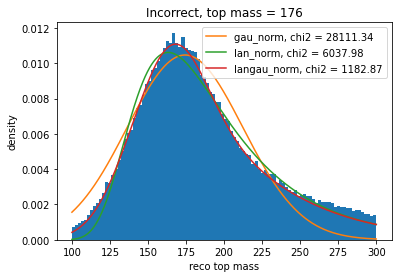

gau [168.72279741  18.38873992]
lan [163.20166806  11.28701401]
langau [153.58283856  18.12697353 169.89912752  14.94801345   0.6873542 ]


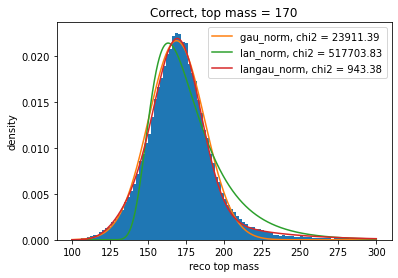

gau [169.50653648  18.46220752]
lan [163.9309324   11.36635843]
langau [153.97862755  17.68268233 170.85525831  14.88717869   0.67585438]


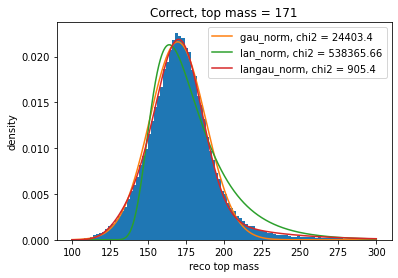

gau [170.42932161  18.51632891]
lan [164.90353428  11.35997939]
langau [154.71243444  17.93922231 171.73459025  14.93144681   0.67938131]


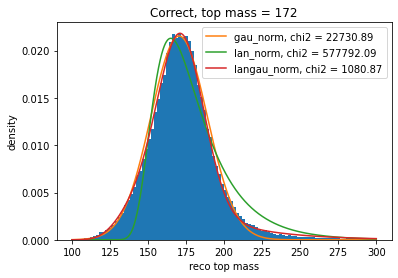

gau [171.24933074  18.68165253]
lan [165.59412499  11.49287726]
langau [176.19037243   9.61190474 166.00430478  17.71412886   0.6931602 ]


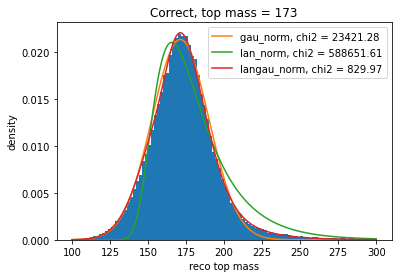

gau [172.15305893  18.78024382]
lan [166.4468367   11.54890275]
langau [177.09879754   9.68867524 166.80058756  17.75368025   0.68866299]


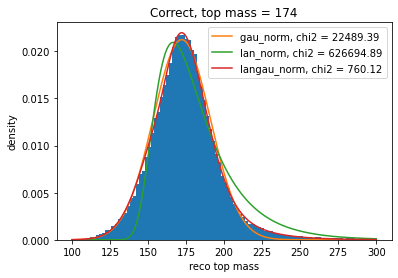

gau [172.98078419  18.73121181]
lan [167.34689732  11.51622083]
langau [157.04172644  17.9701583  174.34002039  15.13064488   0.67937061]


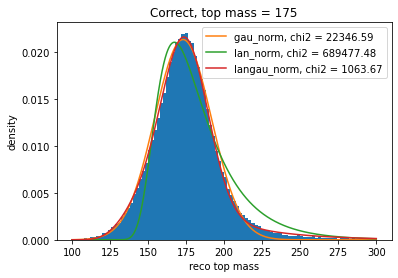

gau [173.84796384  18.89750532]
lan [168.12492388  11.66133277]
langau [157.57838007  17.60627084 175.45087084  14.99476326   0.65757145]


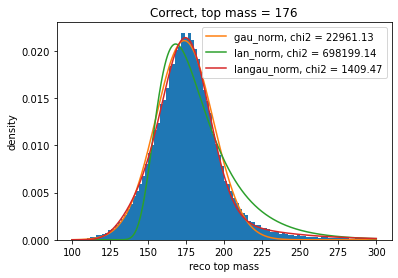

In [61]:
for state_i in [0, 1, 2]:
    for m in mass:
        hist, bin_edges = np.histogram(reco_dic[m][state_dic[m]==state_i], bins=bins, density=True)
        x = np.linspace(100, 300, 10000)

        # Fit to a Gaussian
        popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.5, hist,
                                        p0=(150, 20), method="lm")
        y_gau_norm = gau_norm(x, popt[0], popt[1])
        print('gau', popt)
        chi_gau_norm = chi2_pdf(reco_dic[m][state_dic[m]==state_i], gau_norm(bins[:-1]+1, popt[0], popt[1]))
        
        # Fit to a landau
        popt, pcov = optimize.curve_fit(lan_norm, bin_edges[:-1]+0.5, hist,
                                        p0=(150, 20), method="lm")
        y_lan_norm = lan_norm(x, popt[0], popt[1])
        print('lan', popt)
        chi_lan_norm = chi2_pdf(reco_dic[m][state_dic[m]==1], lan_norm(bins[:-1]+1, popt[0], popt[1]))
        
        # Fit to a Langau
        popt, pcov = optimize.curve_fit(langau_norm, bin_edges[:-1]+0.5, hist,
                                        p0=(150, 20, 150, 20, 0.5), method="lm")
        print('langau', popt)
        y_langau_norm = langau_norm(x, popt[0], popt[1], popt[2], popt[3], popt[4])
        chi_langau_norm = chi2_pdf(reco_dic[m][state_dic[m]==state_i], langau_norm(bins[:-1]+1, popt[0], popt[1], popt[2], popt[3], popt[4]))

        plt.hist(reco_dic[m][state_dic[m]==state_i], bins=bins, density=True)
        plt.plot(x, y_gau_norm, label='gau_norm, chi2 = {}'.format(round(chi_gau_norm, 2)))
        plt.plot(x, y_lan_norm, label='lan_norm, chi2 = {}'.format(round(chi_lan_norm, 2)))
        plt.plot(x, y_langau_norm, label='langau_norm, chi2 = {}'.format(round(chi_langau_norm, 2)))
        plt.title(state_labels[state_i] + ', top mass = {}'.format(m))
        plt.xlabel('reco top mass')
        plt.ylabel('density')
        plt.legend(loc='upper right')
        plt.show()

In [62]:
# Fit different state to different distribution.
# Fit all to two_gau_norm
popt_arr = []
for i, m in enumerate(mass):
    hist, bin_edges = np.histogram(reco_dic[m], bins=bins, density=True)
    popt, pcov = optimize.curve_fit(two_gau_norm, bin_edges[:-1]+0.5, hist,
                                    p0=(150, 100, 100, 100, 0.9), method="lm")
    popt_arr.append(popt)

popt_arr = np.transpose(np.array(popt_arr))
all_a_arr, all_b_arr = [], []
for arr in popt_arr:
    popt, pcov = optimize.curve_fit(linear, mass, arr, method="lm")
    all_a_arr.append(popt[0])
    all_b_arr.append(popt[1])

In [63]:
# Fit unmatched to langau
popt_arr = []
for i, m in enumerate(mass):
    hist, bin_edges = np.histogram(reco_dic[m][state_dic[m]==0], bins=bins, density=True)
    popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.5, hist,
                                    p0=(150, 100), method="lm")
    popt_arr.append(popt)
popt_arr = np.transpose(np.array(popt_arr))
unmatch_a_arr, unmatch_b_arr = [], []
for arr in popt_arr:
    popt, pcov = optimize.curve_fit(linear, mass, arr, method="lm")
    unmatch_a_arr.append(popt[0])
    unmatch_b_arr.append(popt[1])